In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import mean_squared_error


import sys
from GEMM_function_mean_only_0328 import cal_mean

from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

In [2]:
from setup import *
import util_cnn
import util_data
import util_performance
output_folder = "211010"
char_name = '_no_airport_no_gas_coal_combined_oil_combined'
standard = 'const'
run_suffix = '_linearfix'

In [3]:
output_vars = ['pm25', 'pm10', 'so2', 'no2', 'co', 'o3']
#color_list = ['skyblue','burlywood','yellowgreen','gold','lightseagreen','lightsalmon']
#color_list = ['#63B2EE','#76DA91','#F8CB7F','#F89588','#7CD6CF','#9192AB']
color_list = ['#0E72CC','#6CA30F','#F59311','#FA4343','#16AFCC','#85C021']
plot_vars = [0,1,2,3,4,5]
top_models = [(145, 0.3, 6), (145, 0.2, 2), (145, 0.1, 14)]
f_size = (5,4)

(train_images,train_y,weights_training,
    validation_images,validation_y,weights_validation,
    test_images,test_y,weights_testing,
    train_mean_images,validation_mean_images,test_mean_images,
    index_cnn_training,index_cnn_validation,index_cnn_testing,
    sector_max) = util_data.read_data(char_name, standard, radius=30, output_var=[0,1,2,3,4,5])

## Different Pollution Variables

In [4]:
#### USE MULTITASK LEARNING RESULTS ####
# results = []
# plot_vars = [0,1,2,3,4,5]
# top_models_multi = [(88, 0.2, -1), (157, 0.2, -1), (81, 0.2, -1)]
# run_suffix = "_hp"

# # model ensembling
# output_multi_train, output_multi_validation, output_multi_test = \
#     util_cnn.get_ensembled_prediction("211010", [0,1,2,3,4,5], 30, top_models_multi, len(train_y), run_suffix=run_suffix)


# for air_var in plot_vars:
    
    
#     # true output
#     output_training = train_y[:, air_var]
#     output_validation = validation_y[:, air_var]
#     output_testing = test_y[:, air_var]

#     # model ensembling
#     output_cnn_train = output_multi_train[:, air_var]
#     output_cnn_validation = output_multi_validation[:, air_var]
#     output_cnn_test = output_multi_test[:, air_var]

#     cnn_train_loss=mean_squared_error(output_training, output_cnn_train, sample_weight=weights_training)
#     cnn_validation_loss=mean_squared_error(output_validation, output_cnn_validation, sample_weight=weights_validation)
#     cnn_test_loss=mean_squared_error(output_testing, output_cnn_test, sample_weight=weights_testing)
#     cnn_train_r2=util_performance.w_r2(output_cnn_train, output_training, weights_training)
#     cnn_validation_r2=util_performance.w_r2(output_cnn_validation, output_validation, weights_validation)
#     cnn_test_r2=util_performance.w_r2(output_cnn_test, output_testing, weights_testing)

#     results.append([cnn_train_loss, cnn_validation_loss, cnn_test_loss, cnn_train_r2, cnn_validation_r2, cnn_test_r2])

# results = pd.DataFrame(np.array(results), columns=['train_mse','validation_mse','test_mse','train_r2','validation_r2','test_r2'])

# width = 0.7 / len(plot_vars)


In [5]:
results = []
plot_vars = [0,1,2,3,4,5]
top_models_cnn = [[(145, 0.3, 6)],[(145, 0.2, 6)],[(145, 0.2, 8)],[(145, 0.2, 0)],[(145, 0.2, 6)],[(145, 0.2, 5)]]
run_suffix = "_linearfix"


for air_var, top_models in zip(plot_vars, top_models_cnn):
    
    # model ensembling
    output_cnn_train, output_cnn_validation, output_cnn_test = \
        util_cnn.get_ensembled_prediction("211010", [air_var], 30, top_models, len(train_y), run_suffix=run_suffix)
    
    # true output
    output_training = train_y[:, air_var]
    output_validation = validation_y[:, air_var]
    output_testing = test_y[:, air_var]

    # model ensembling
    output_cnn_train = output_cnn_train[:, 0]
    output_cnn_validation = output_cnn_validation[:, 0]
    output_cnn_test = output_cnn_test[:, 0]

    cnn_train_loss=mean_squared_error(output_training, output_cnn_train, sample_weight=weights_training)
    cnn_validation_loss=mean_squared_error(output_validation, output_cnn_validation, sample_weight=weights_validation)
    cnn_test_loss=mean_squared_error(output_testing, output_cnn_test, sample_weight=weights_testing)
    cnn_train_r2=util_performance.w_r2(output_cnn_train, output_training, weights_training)
    cnn_validation_r2=util_performance.w_r2(output_cnn_validation, output_validation, weights_validation)
    cnn_test_r2=util_performance.w_r2(output_cnn_test, output_testing, weights_testing)

    results.append([cnn_train_loss, cnn_validation_loss, cnn_test_loss, cnn_train_r2, cnn_validation_r2, cnn_test_r2])

results = pd.DataFrame(np.array(results), columns=['train_mse','validation_mse','test_mse','train_r2','validation_r2','test_r2'])

width = 0.7 / len(plot_vars)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


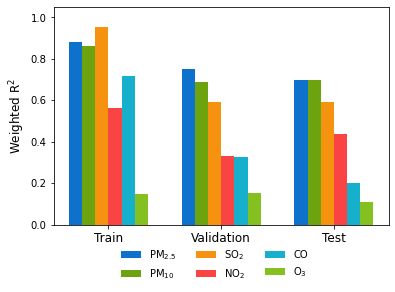

In [6]:
#Figure 7

%run fig_tool.py
%matplotlib inline

#fig, ax = universal_fig(figsize=f_size)
output_var_labels = ['PM$_{2.5}$','PM$_{10}$', 'SO$_2$', 'NO$_2$', 'CO', 'O$_3$']
fig, ax = plt.subplots()
for i in range(len(plot_vars)):
    ax.bar(np.arange(3)+(i-len(plot_vars)/2+0.5)*width, results.iloc[i][['train_r2', 'validation_r2','test_r2']], width, color=color_list[i], label=output_var_labels[i])
ax.legend(bbox_to_anchor=(0.48,-0.3),loc=8,ncol=3,frameon=False)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Train','Validation','Test'],fontdict={'family':'Arial'},fontsize=12)
ax.set_ylim(0,1.05)
ax.set_ylabel('Weighted R$^2$',fontdict={'family':'Arial'},fontsize=12)

fig.savefig(output_dir+output_folder+"/plots/Figure 7.png", bbox_inches='tight',dpi=300)
fig.show()


## Different Radius 

In [7]:
output_var = 0
image_radii = [10, 20, 30]
top_models_radii = [[(105, 0.2, -1)],#, (237, 0.2, -1), (96, 0.2, -1)],
                    [(1, 0.2, -1)],#,(88, 0.2, -1), (93, 0.2, -1)],
                    [(145, 0.3, 6)]]#, (145, 0.2, 2), (145, 0.1, 14)]]

output_training = train_y[:, output_var][:, np.newaxis]
output_validation = validation_y[:, output_var][:, np.newaxis]
output_testing = test_y[:, output_var][:, np.newaxis]

results = []

In [8]:
for rad, top_models in zip(image_radii, top_models_radii):
    if top_models[0][-1] == -1:
        run_suffix = '_hp'
    else:
        run_suffix = '_linearfix'
    output_cnn_train, output_cnn_validation, output_cnn_test = \
        util_cnn.get_ensembled_prediction("211010", [output_var], int(rad), top_models, len(output_training), run_suffix=run_suffix)

    cnn_train_loss=mean_squared_error(output_training, output_cnn_train, sample_weight=weights_training)
    cnn_validation_loss=mean_squared_error(output_validation, output_cnn_validation, sample_weight=weights_validation)
    cnn_test_loss=mean_squared_error(output_testing, output_cnn_test, sample_weight=weights_testing)
    cnn_train_r2=util_performance.w_r2(output_cnn_train, output_training, weights_training)
    cnn_validation_r2=util_performance.w_r2(output_cnn_validation, output_validation, weights_validation)
    cnn_test_r2=util_performance.w_r2(output_cnn_test, output_testing, weights_testing)

    results.append([cnn_train_loss, cnn_validation_loss, cnn_test_loss, cnn_train_r2, cnn_validation_r2, cnn_test_r2])
    
results = pd.DataFrame(np.array(results), columns=['train_mse','validation_mse','test_mse','train_r2','validation_r2','test_r2'])

width = 0.7 / len(image_radii)

/home/jtl/Documents/qingyi/cnn_pollution/fig_tool.py:92: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  matplotlib.rc('savefig',bbox='tight',format='pdf',frameon=False,pad_inches=0.05)


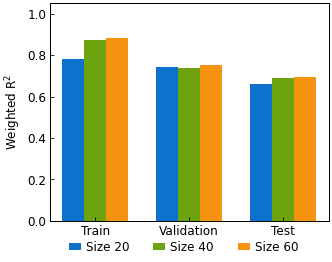

In [28]:
# Figure 3_SI

fig, ax = universal_fig(figsize=f_size)
for i in range(len(image_radii)):
    ax.bar(np.arange(3)+(i-len(image_radii)/2+0.5)*width, 
           results.iloc[i][['train_r2', 'validation_r2','test_r2']], 
           width, color=color_list[i], label='Size '+ str(2*image_radii[i]))
ax.legend(bbox_to_anchor=(0.48,-0.2),loc=8,ncol=3,frameon=False)
ax.set_ylim(0,1.05)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Train','Validation','Test'],fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('Weighted R$^2$',fontdict={'family':'Arial'},fontsize=12);
fig.savefig(output_dir+output_folder+"/plots/Figure 3_SI.png", bbox_inches='tight',dpi=300)
#fig.show()


In [10]:
plt.rcParams.update({'font.size': 20})

## Top Model

In [4]:
model_idx = 6
hp_idx = 145
linear_coef = 0.3
run_suffix = '_linearfix'

plt.rcParams.update({'font.size': 20})

# indices of variables to modify in scenario testing
# industrial coal, transportation, residential coal
# INDICES NEED TO CHANGE IN THE UPDATED DATASET
#200222 and 200317
scenario_variables = [0,1,4]
scenario_name = ['res_col', 'ind_col', 'trn_oil']
colors = ['salmon','mediumseagreen','mediumslateblue']

variables_export = ['COAL', 'INDCT',
                    'INDOT', 'SVC', 'OIL',
                    'DEM', 'rain', 'TEM']

# require gradients to be positive: AGO, INDCT, SVC, SVO, TRANS, COAL (RDC+AGC)
major_variables = [0,1,2,3,4]
char_name = '_no_airport_no_gas_coal_combined_oil_combined'
standard = 'const'

In [5]:
# Input
station_prov = pd.read_excel(data_dir+'raw/stationID_province_region.xlsx')
(train_images,train_y,train_weights,
    validation_images,validation_y,validation_weights,
    test_images,test_y,test_weights,
    train_mean_images,validation_mean_images,test_mean_images,
    index_cnn_training,index_cnn_validation,index_cnn_testing,
    sector_max) = util_data.read_data(char_name, standard, radius=30, output_var=[0])

control_var_training, control_var_validation, control_var_testing, control_scale = \
    util_data.get_control_variables(filename='agriculture_variables_station.xlsx',
                                train_index=index_cnn_training,
                                validation_index=index_cnn_validation,
                                test_index=index_cnn_testing)
if standard == 'const':
    input_raw_training = train_images
    input_raw_validation = validation_images
    input_raw_testing = test_images

    for i,v in enumerate(variables_export):
        input_raw_training[:,:,:,i] = train_images[:,:,:,i]*sector_max[v]
        input_raw_validation[:,:,:,i] = validation_images[:,:,:,i]*sector_max[v]
        input_raw_testing[:,:,:,i] = test_images[:,:,:,i]*sector_max[v]

    input_raw_training = input_raw_training[:,:,:,np.array(major_variables)]
    input_raw_validation = input_raw_validation[:,:,:,np.array(major_variables)]
    input_raw_testing = input_raw_testing[:,:,:,np.array(major_variables)]
else:
    print("Go get raw values!")


In [6]:
# unit: tons
input_emissions =  np.squeeze(np.concatenate((input_raw_training, input_raw_validation, input_raw_testing)))

# a list of station codes (string)
indices = np.concatenate((index_cnn_training, index_cnn_validation, index_cnn_testing))
trainvalte = np.concatenate((np.zeros(len(index_cnn_training)), np.ones(len(index_cnn_validation)), np.zeros(len(index_cnn_testing))+2))
observed_y = np.squeeze(np.concatenate((train_y, validation_y, test_y)))
weights = np.squeeze(np.concatenate((train_weights, validation_weights, test_weights)))


In [7]:
print("Model: ", model_idx)

with open(output_dir + output_folder + "/"+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+"_results"+run_suffix+".pkl", "rb") as f:
    scenario_output = np.array(pkl.load(f))[:, :, :, 0]
    pkl.load(f)  #gradients
    pkl.load(f) #gradients_masked
    pkl.load(f) # gradients_full
    mask_full_df = pkl.load(f)
    id10_full = pkl.load(f)
    indices = pkl.load(f)
    fitted_y_train = pkl.load(f)
    fitted_y_val = pkl.load(f)
    fitted_y_test = pkl.load(f)

with open(output_dir + output_folder + "/"+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+"_gradients_by_cell"+run_suffix+".pkl", "rb") as f:
    tr_gradients = pkl.load(f)
    val_gradients = pkl.load(f)
    te_gradients = pkl.load(f)
    tr_gradients_mean = pkl.load(f)
    val_gradients_mean = pkl.load(f)
    te_gradients_mean = pkl.load(f)

fitted_y = np.squeeze(np.concatenate((fitted_y_train, fitted_y_val, fitted_y_test)))

Model:  6


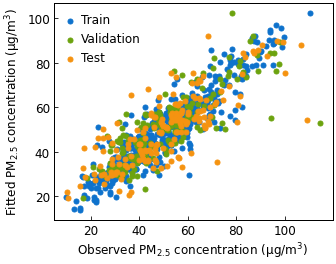

In [15]:
# Figure 1

### ------------ Plot measured vs modelled ------------ ###
fig, ax = universal_fig(figsize=f_size)
ax.scatter(train_y, fitted_y_train, color=color_list[0], label='Train')#alpha = 0.5透明度
ax.scatter(validation_y, fitted_y_val, color=color_list[1], label='Validation')
ax.scatter(test_y, fitted_y_test, color=color_list[2], label='Test')
ax.set_xlabel('Observed PM$_{2.5}$ concentration ($\mu$g/$m^3$)',fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('Fitted PM$_{2.5}$ concentration ($\mu$g/$m^3$)',fontdict={'family':'Arial'},fontsize=12)
[label.set_fontsize(12) for label in (ax.get_xticklabels() + ax.get_yticklabels())]
ax.legend(frameon=False)
fig.savefig(output_dir+output_folder+"/plots/Figure 1.png", bbox_inches='tight',dpi=300)

#pd.DataFrame(np.array([indices,fitted_y,observed_y,trainvalte, fitted_y-observed_y]).T,
#             columns=['index','modelled','measured','train/val/te','difference'])#.to_csv("../output/"+\
            #output_folder+"/"+str(index)+"_model_performance.csv",index=False)

(3, 12, 943)


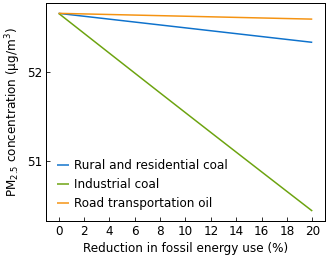

In [16]:
### ------------ Plot scenario PM ------------ ###
#Figure 2a
fig, ax = plt.subplots(figsize=f_size)

#plt.subplots_adjust(left=0.2,bottom=0.2,top=0.8,hspace=0.2,wspace=0.3)

pct = np.arange(0, 22, 2)
print(scenario_output.shape)
scenario_name = ['Rural and residential coal', 'Industrial coal', 'Road transportation oil']
for s in range(np.shape(scenario_output)[0]):
    # starting from 1 because the first column is the actual value
    s_output = np.average(scenario_output[s,1:,:], axis=1, weights=weights)
    ax.plot(pct, s_output, label=scenario_name[s], color=color_list[s])
ax.set_xticks(pct)
ax.tick_params(labelsize=12)
ax.set_xlabel('Reduction in fossil energy use (%)',fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('PM$_{2.5}$ concentration ($\mu$g/$m^3$)',fontdict={'family':'Arial'},fontsize=12)
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(frameon=False,fontsize=12)

#ax.legend(bbox_to_anchor=(0.48,-0.3),loc=8,ncol=3,frameon=True)
#plt.tight_layout()

fig.savefig(output_dir+output_folder+"/plots/Figure 2(a).png",dpi=300)

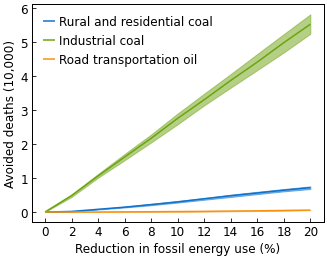

In [17]:
### ------------ Plot scenario avoided death ------------ ###
#Figure 2b
# columns: 'variable','scenario','station_index','p0','p1','pop','mean','p5','p95'
fig, ax = plt.subplots(figsize=(5/1299*1359,4))

#plt.subplots_adjust(left=0.2,bottom=0.2,top=0.8,hspace=0.2,wspace=0.3)

scenario_ad = pd.read_csv(output_dir + output_folder + '/'+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+'_scenario_ad_csv'+run_suffix+'.csv')
scenario_ad = scenario_ad.groupby(['variable','scenario'], as_index=False).sum()[['variable','scenario','mean','p5','p95','pop']]
scenario_ad = scenario_ad.sort_values(by=['variable','scenario'], ascending=True)
for v in range(np.shape(scenario_output)[0]):
    ax.fill_between(pct, -scenario_ad[scenario_ad['variable'] == v]['p5'], \
                    -scenario_ad[scenario_ad['variable'] == v]['p95'], \
                    color=color_list[v], alpha=0.5)
    ax.plot(pct, -scenario_ad[scenario_ad['variable'] == v]['mean'], color = color_list[v], label=scenario_name[v])
ax.set_xticks(pct)
ax.tick_params(labelsize=12)
ax.set_xlabel('Reduction in fossil energy use (%)',fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('Avoided deaths (10,000)',fontdict={'family':'Arial'},fontsize=12)
ax.legend(frameon=False,fontsize=12)

#plt.tight_layout()

#fig.show()
fig.savefig(output_dir+output_folder+"/plots/Figure 2(b).png",dpi=300)


In [25]:
scenario_ad[scenario_ad['scenario']==11]

,variable,scenario,mean,p5,p95,pop
10,0,11,-0.717,-0.753,-0.676,136128.777
21,1,11,-5.520,-5.811,-5.240,136128.777
32,2,11,-0.057,-0.060,-0.052,136128.777


(3, 12, 943)


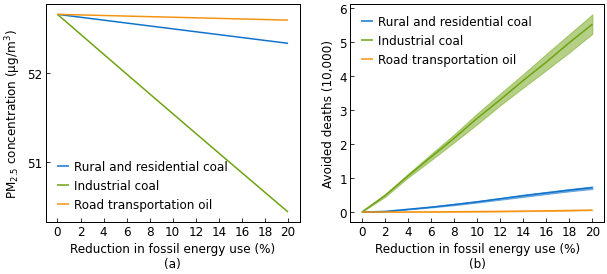

In [18]:
# Figure 2

fig, (ax1,ax2) = plt.subplots(figsize=(10,4),ncols=2)

#plt.subplots_adjust(left=0.2,bottom=0.2,top=0.8,hspace=0.2,wspace=0.3)

pct = np.arange(0, 22, 2)
print(scenario_output.shape)
scenario_name = ['Rural and residential coal', 'Industrial coal', 'Road transportation oil']
for s in range(np.shape(scenario_output)[0]):
    # starting from 1 because the first column is the actual value
    s_output = np.average(scenario_output[s,1:,:], axis=1, weights=weights)
    ax1.plot(pct, s_output, label=scenario_name[s], color=color_list[s])
ax1.set_xticks(pct)
ax1.tick_params(labelsize=12)
ax1.set_xlabel('Reduction in fossil energy use (%)\n(a)',fontdict={'family':'Arial'},fontsize=12)
ax1.set_ylabel('PM$_{2.5}$ concentration ($\mu$g/$m^3$)',fontdict={'family':'Arial'},fontsize=12)
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
ax1.legend(frameon=False,fontsize=12)

#ax.legend(bbox_to_anchor=(0.48,-0.3),loc=8,ncol=3,frameon=True)
#plt.tight_layout()

scenario_ad = pd.read_csv(output_dir + output_folder + '/'+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+'_scenario_ad_csv'+run_suffix+'.csv')
scenario_ad = scenario_ad.groupby(['variable','scenario'], as_index=False).sum()[['variable','scenario','mean','p5','p95','pop']]
scenario_ad = scenario_ad.sort_values(by=['variable','scenario'], ascending=True)
for v in range(np.shape(scenario_output)[0]):
    ax2.fill_between(pct, -scenario_ad[scenario_ad['variable'] == v]['p5'], \
                    -scenario_ad[scenario_ad['variable'] == v]['p95'], \
                    color=color_list[v], alpha=0.5)
    ax2.plot(pct, -scenario_ad[scenario_ad['variable'] == v]['mean'], color = color_list[v], label=scenario_name[v])
ax2.set_xticks(pct)
ax2.tick_params(labelsize=12)
ax2.set_xlabel('Reduction in fossil energy use (%)\n(b)',fontdict={'family':'Arial'},fontsize=12)
ax2.set_ylabel('Avoided deaths (10,000)',fontdict={'family':'Arial'},fontsize=12)
ax2.legend(frameon=False,fontsize=12)

#plt.tight_layout()

fig.savefig(output_dir+output_folder+"/plots/Figure 2.png",dpi=300)

In [9]:
# read marginal damage (full dataframe) (unit: $/10k ton)
md_mean_full = pd.read_csv(output_dir+output_folder+"/"+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+"_md_mean_full"+run_suffix+".csv")
# (summed by id10)
md = pd.read_csv(output_dir+output_folder+"/"+str(hp_idx)+"_"+str(linear_coef)+"_"+str(model_idx)+"_md_mean"+run_suffix+".csv")
md = md[((md['id10'] != 8888888)&(md['id10'] != 9999999))]

# filter emissions from images to by id10 (unit: ton)
emissions_by_cell = np.reshape(input_emissions, (-1, len(major_variables)))
emissions_by_cell = pd.DataFrame(np.insert(emissions_by_cell, 0, md_mean_full['id10'].to_numpy(), axis=1),
                                 columns=['id10']+[variables_export[i] for i in major_variables])
# already checked: mean and max and min are the same one id10 per sector has one emission value
emissions_by_cell = emissions_by_cell.groupby('id10', as_index=False).mean()
emissions_by_cell = emissions_by_cell[((emissions_by_cell['id10'] != 8888888)&(emissions_by_cell['id10'] != 9999999))]
# it's also fine if these two cells are not taken out as they have 0 emissions for all sectors

print('Sector, Weighted Average, 95 percentile, 5 percentile')
# weight marginal damage by emissions
for i in major_variables:
    print("%s: %.2f, %.2f, %.2f" % (variables_export[i],
                        np.average(md[variables_export[i]]/10000, weights=emissions_by_cell[variables_export[i]]),
                        np.percentile(md[variables_export[i]]/10000, 95),
                        np.percentile(md[variables_export[i]]/10000, 5)))

    '''
    # check the influence of extreme values
    # prints weighted average with 99% percentile of both emissions and marginal damage
    p = np.array((emissions_by_cell[variables_export[i]].to_numpy(), md[variables_export[i]].to_numpy()/10000)).T
    pct = np.percentile(p, 99, axis=0)
    print(np.average(p[((p[:,1]<pct[1])&(p[:,0]<pct[0])),1], weights = p[((p[:,1]<pct[1])&(p[:,0]<pct[0])),0]))
    '''
    '''
    # checking the relationship between emission magnitude and marginal damage magnitude
    # not correlated
    plt.figure()
    plt.scatter(p[((p[:,1]<pct[1])&(p[:,0]<pct[0])),0], p[((p[:,1]<pct[1])&(p[:,0]<pct[0])),1])
    plt.savefig('temp'+str(i)+'.png')
    '''
print('ALL COAL: %.2f, %.2f, %.2f' % (np.average(md[[variables_export[i] for i in [0,1,3]]].to_numpy().flatten()/10000,
                             weights=emissions_by_cell[[variables_export[i] for i in [0,1,3]]].to_numpy().flatten()),
     np.percentile(md[[variables_export[i] for i in [0,1,3]]].to_numpy().flatten()/10000,95),
     np.percentile(md[[variables_export[i] for i in [0,1,3]]].to_numpy().flatten()/10000, 5)))

print('ALL OIL: %.2f, %.2f, %.2f' % (np.average(md[[variables_export[i] for i in [2,4]]].to_numpy().flatten()/10000,
                             weights=emissions_by_cell[[variables_export[i] for i in [2,4]]].to_numpy().flatten()),
     np.percentile(md[[variables_export[i] for i in [2,4]]].to_numpy().flatten()/10000,95),
     np.percentile(md[[variables_export[i] for i in [2,4]]].to_numpy().flatten()/10000, 5)))

print('ALL: %.2f, %.2f, %.2f' % (np.average(md[[variables_export[i] for i in major_variables]].to_numpy().flatten()/10000,
                             weights=emissions_by_cell[[variables_export[i] for i in major_variables]].to_numpy().flatten()),
     np.percentile(md[[variables_export[i] for i in major_variables]].to_numpy().flatten()/10000,95),
     np.percentile(md[[variables_export[i] for i in major_variables]].to_numpy().flatten()/10000, 5)))

print('ALL STD: %.2f' % np.sqrt(np.cov(md[[variables_export[i] for i in major_variables]].to_numpy().flatten()/10000,
                fweights=emissions_by_cell[[variables_export[i] for i in major_variables]].to_numpy(dtype=int).flatten())))      



Sector, Weighted Average, 95 percentile, 5 percentile
COAL: 216.65, 362.64, -0.08
INDCT: 29.32, 39.65, -0.13
INDOT: 14.89, 15.84, -0.20
SVC: 151.41, 266.66, -2.77
OIL: 11.57, 17.21, -0.17
ALL COAL: 37.34, 268.52, -0.47
ALL OIL: 13.06, 16.54, -0.18
ALL: 32.88, 201.40, -0.27
ALL STD: 47.71


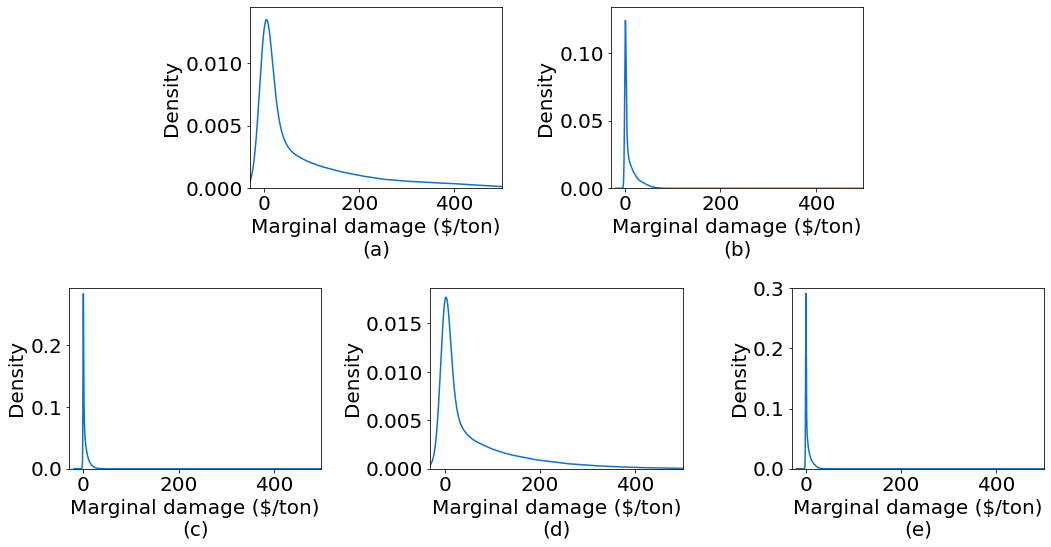

In [12]:
### ------------ Plot marginal damage histogram by sector ------------ ###
# Figure_SI

plt.figure(figsize=(15,8))

gs = gridspec.GridSpec(2,6)

pos = [gs[0,1:3],gs[0,3:5],gs[1,0:2],gs[1,2:4],gs[1,4:6]]
label = ['a','b','c','d','e']

for i in major_variables:
    ax = plt.subplot(pos[i])
    #n, bins, patches = ax.hist(md[variables_export[i]]/10000, density=True, color=color_list[0])
    #sns.displot(md[variables_export[i]]/10000, color=color_list[0])
    probDensityFun = gaussian_kde(md[variables_export[i]]/10000)
    if i==0 or i==3:
        x_min=-100
        x_max=1500
    else:
        x_min=-20
        x_max=500
    temp = np.linspace(x_min,x_max,10000)
    pdf = probDensityFun.pdf(temp)
    plt.plot(temp,pdf,'r',color=color_list[0])
    ax.set_xlabel('Marginal damage ($/ton)\n('+label[i]+')')
    ax.set_ylabel('Density')
    ax.set_xlim(x_min,x_max)
    if max(pdf)>0.08:
        ax.set_ylim(0,max(pdf)+0.01)
    else:
        ax.set_ylim(0,max(pdf)+0.001)
    ax.set_xlim([-30,500])

plt.tight_layout()
plt.savefig(output_dir+output_folder+"/plots/Figure_S2.png", bbox_inches='tight',dpi=300)


/home/jtl/Documents/qingyi/cnn_pollution/fig_tool.py:92: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  matplotlib.rc('savefig',bbox='tight',format='pdf',frameon=False,pad_inches=0.05)


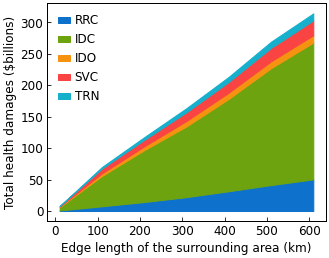

In [21]:
### ------------ Plot total damage by distance from source ------------ ###
#Figure 5

# take out id10 and change money unit
# billion dollars / 10k ton emissions
md_mean_full = md_mean_full.to_numpy()[:, 1:] / 1e9

# calculate total damage
# shape = (num stations, 61, 61, num major variables)
# billion dollars
td_total = np.multiply(np.reshape(md_mean_full, (-1,61,61,len(major_variables))), input_emissions/1e4)

label_name = ['RRC','IDC', 'IDO', 'SVC', 'TRN']

middle_pixel = 30
pixel_step = 5
cumulative_output = [] #np.zeros(len(np.arange(0, 31, 10))) + bias
for dist in np.arange(0, 31, pixel_step):
    temp = []
    for sector in major_variables:
        lower_index = middle_pixel-dist
        upper_index = middle_pixel+dist+1

        temp.append(np.sum(td_total[:, lower_index:upper_index, lower_index:upper_index, sector]))
    cumulative_output.append(temp)
cumulative_output = np.array(cumulative_output)
cu = np.zeros(len(np.arange(0, 31, pixel_step)))

fig, ax = universal_fig(figsize=f_size)
for i, sector in enumerate(major_variables):
    #ax.fill_between(np.arange(0, 31, pixel_step), cu, cu + cumulative_output[:, sector], label=variables_export[sector],color=color_list[i], alpha=0.75)
    ax.fill_between(np.arange(10, 620, pixel_step*20), cu, cu + cumulative_output[:, sector], label=label_name[sector],color=color_list[i])
    cu = cu + cumulative_output[:, sector]
ax.set_xlabel('Edge length of the surrounding area (km)',fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('Total health damages ($billions)',fontdict={'family':'Arial'},fontsize=12)
ax.tick_params(labelsize=12)
#ax.legend(bbox_to_anchor=(1,1))
ax.legend(loc=2,frameon=False)
fig.savefig(output_dir+output_folder+"/plots/Figure 5.png", bbox_inches='tight',dpi=300)


In [26]:
td_sector_total

array([ 50.35243472, 217.62635338,  11.68147086,  23.63974682,
        11.22526304])

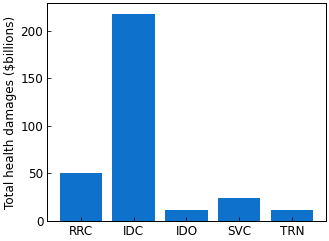

In [22]:
### ------------ Plot damage by sector ------------ ###
# Figure 4a
fig, ax = universal_fig(figsize=f_size)
td_sector_total = np.sum(td_total, axis=(0,1,2))
ax.bar(np.arange(len(td_sector_total)), td_sector_total, tick_label = [label_name[v] for v in major_variables],color=color_list[0])
# ax.set_xlabel('Sectors',fontdict={'family':'Arial'},fontsize=12)
ax.set_ylabel('Total health damages ($billions)',fontdict={'family':'Arial'},fontsize=12)
fig.savefig(output_dir+output_folder+"/plots/Figure 4(a).png", bbox_inches='tight',dpi=300)
#fig.show()


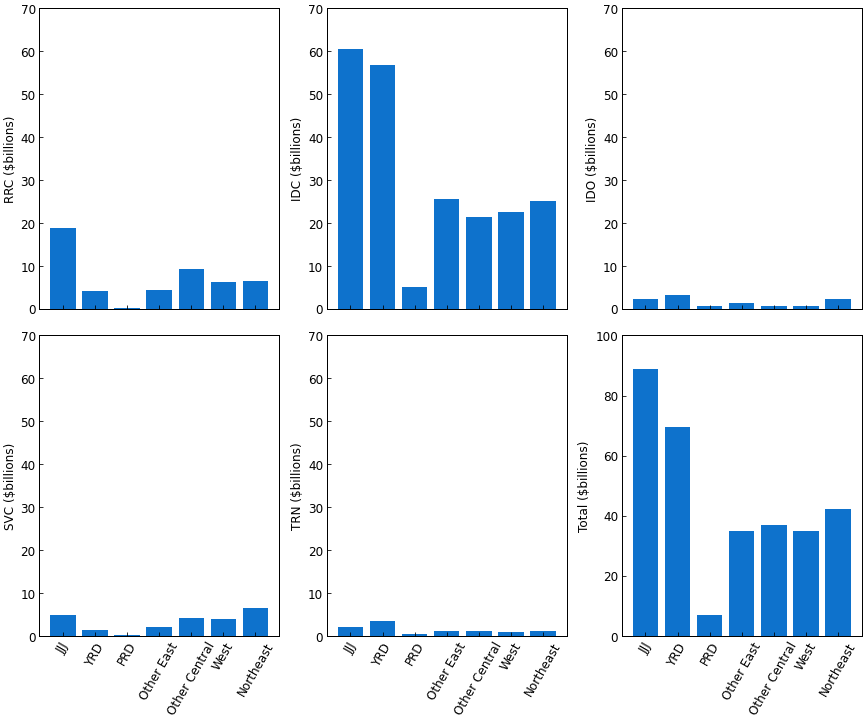

In [27]:
### ------------ Plot damage by provincial regions ------------ ###
# Fig 4b
td_by_station = np.sum(td_total, axis=(1,2))
td_total_by_station = np.sum(td_by_station, axis=1)
td_by_station = pd.DataFrame(td_by_station, columns =[variables_export[v] for v in major_variables])
td_by_station['Total'] = td_total_by_station
td_by_station['station_code'] = indices
td_by_station = pd.merge(td_by_station, station_prov, on='station_code')
td_by_region = td_by_station.groupby('region', as_index=False).sum()

region_code = {1:'JJJ', 2:'YRD', 3:'PRD', 4:'Other East', 5:'Other Central', 6:'West', 7:'Northeast'}
#fig, ax = plt.subplots(nrows=len(major_variables)+1, sharex=True, figsize=(5,10))
fig, ax = plt.subplots(nrows=2,ncols=3, sharex=True, figsize=(12,10),constrained_layout=True)
plot_variables = [variables_export[v] for v in major_variables] + ['Total']
plot_variables_name = [label_name[v] for v in major_variables] + ['Total']
'''
for i in range(len(plot_variables)):
    col = plot_variables[i]
    ax[i].bar(np.arange(len(td_by_region)), td_by_region[col], tick_label=[region_code[r] for r in td_by_region['region']],color=color_list[0])
    ax[i].set_ylabel(col + " ($Billions)")
    if i>3:
        ax[i].set_ylim(0,10)
    else:
        ax[i].set_ylim(0,100)

for i in range(3):
    col = plot_variables[5-i]
    col_name = plot_variables_name[5-i]
    ax[0][i].bar(np.arange(len(td_by_region)), td_by_region[col], tick_label=[region_code[r] for r in td_by_region['region']],color=color_list[0])
    ax[0][i].set_ylabel(col_name + " ($billions)")
    ax[0][i].set_ylim(0,50)
'''
for i in range(6):
    col = plot_variables[i]
    col_name = plot_variables_name[i]
    ax[i//3][i%3].bar(np.arange(len(td_by_region)), td_by_region[col], tick_label=[region_code[r] for r in td_by_region['region']],color=color_list[0])
    ax[i//3][i%3].set_ylabel(col_name + " ($billions)")
#     ax[i//3][i%3].set_ylabel("Total health damages ($billions)")
#     ax[i//3][i%3].set_title(col_name)
    if i == 5:
        ax[i//3][i%3].set_ylim(0,100)
    else:
        ax[i//3][i%3].set_ylim(0,70)
    ax[i//3][i%3].set_xticklabels(ax[1][i%3].get_xticklabels(),rotation=60)

#plt.xticks(rotation = 60)
fig.savefig(output_dir+output_folder+"/plots/Figure 4(b).png", bbox_inches='tight',dpi=300)
#fig.show()
